# Sentimental Analysis - ML Mini Project 2

## Imports

In [1]:
!pip install datasets pandas seaborn numpy matplotlib beautifulsoup4 nltk tensorflow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.0 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

## Functions

In [3]:
def preprocess_text(sen):
    # Removing HTML tags
    sentence = BeautifulSoup(sen, "html.parser").get_text()

    # Lowercasing
    sentence = sentence.lower()

    # Remove punctuations and numbers
    sentence = re.sub(r'[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Stopwords removal
    stop_words = set(stopwords.words('english'))
    sentence = " ".join([word for word in sentence.split() if word not in stop_words])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    sentence = " ".join([lemmatizer.lemmatize(word) for word in sentence.split()])

    return sentence

## Uploads

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
#IMDB dataset in HuggingFace
ds = load_dataset("nocode-ai/imdb-movie-reviews")
df = ds["train"].to_pandas()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


IMDB%20Dataset.csv:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Data Analysis & Preprocessing

In [6]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


<ipython-input-7-f03a319b2d28>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=["#FF5733", "#3498DB"])


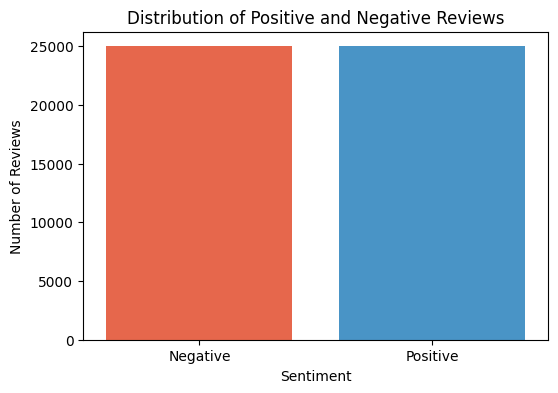

In [7]:
sentiment_counts = df["sentiment"].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=["#FF5733", "#3498DB"])

plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.ylabel("Number of Reviews")
plt.xlabel("Sentiment")
plt.title("Distribution of Positive and Negative Reviews")
plt.show()

In [8]:
positive_review = df[df['sentiment'] == 'positive']['review'].iloc[0]
negative_review = df[df['sentiment'] == 'negative']['review'].iloc[0]

print("First Positive Review:\n", positive_review)
print("\nFirst Negative Review:\n", negative_review)


First Positive Review:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of th

In [9]:
df["cleaned_review"] = df["review"].apply(preprocess_text)

In [10]:
positive_review = df[df['sentiment'] == 'positive']['cleaned_review'].iloc[0]
negative_review = df[df['sentiment'] == 'negative']['cleaned_review'].iloc[0]

print("First Positive Cleaned Review:\n", positive_review)
print("\nFirst Negative Cleaned Review:\n", negative_review)

First Positive Cleaned Review:
 one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill 

## Modeling

### Data Splitting

In [11]:
# Define features and labels
X = df["cleaned_review"]
y = df["sentiment"].map({'positive': 1, 'negative': 0})  # Convert labels to binary (1 = positive, 0 = negative)

# First, split into 85% train and 15% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)


# Print dataset sizes
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 42500
Test set size: 7500


### Initialization

#### TF-IDF for SVM and Naïve Bayes

In [12]:
# Term Frequency-Inverse Document Frequency
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test set
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Print shape of feature matrices
print(f"Train TF-IDF shape: {X_train_tfidf.shape}")
print(f"Test TF-IDF shape: {X_test_tfidf.shape}")

Train TF-IDF shape: (42500, 5000)
Test TF-IDF shape: (7500, 5000)


#### Tokenization for LSTM

In [13]:
# Define hyperparameters
max_vocab = 10000  # Vocabulary size
max_length = 200  # Max words per review

# Initialize tokenizer and fit on training data
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Print shape of padded sequences
print(f"Train padded shape: {X_train_pad.shape}")
print(f"Test padded shape: {X_test_pad.shape}")

Train padded shape: (42500, 200)
Test padded shape: (7500, 200)


### Training

#### Naïve Bayes

In [14]:
# Hyperparameter grid
param_grid = {'alpha': [0.1, 0.5, 1, 5, 10, 20]}

# Grid Search using cross-validation
nb_grid = GridSearchCV(MultinomialNB(), param_grid, scoring='accuracy', cv=3, n_jobs=-1)
nb_grid.fit(X_train_tfidf, y_train)

# Get best hyperparameter based on validation set
best_alpha = nb_grid.best_params_['alpha']
print(f"Best alpha for Naïve Bayes: {best_alpha}")

# Train Naïve Bayes with the best alpha
nb_best = MultinomialNB(alpha=best_alpha)
nb_best.fit(X_train_tfidf, y_train)

# Validate model
y_test_pred_nb = nb_best.predict(X_test_tfidf)
print("Naïve Bayes Test Accuracy:", accuracy_score(y_test, y_test_pred_nb))

Best alpha for Naïve Bayes: 10
Naïve Bayes Test Accuracy: 0.8638666666666667


#### SVM

In [15]:
# Hyperparameter grid
param_grid = {'C': [0.01, 0.05, 0.1, 0.2, 1, 10, 100]}

# Grid Search using validation set
svm_grid = GridSearchCV(LinearSVC(), param_grid, scoring='accuracy', cv=3, n_jobs=-1)
svm_grid.fit(X_train_tfidf, y_train)

# Get best C
best_C = svm_grid.best_params_['C']
print(f"Best C for SVM: {best_C}")

# Train SVM with best C
svm_best = LinearSVC(C=best_C)
svm_best.fit(X_train_tfidf, y_train)

# Validate model
y_test_pred_svm = svm_best.predict(X_test_tfidf)
print("SVM Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))


Best C for SVM: 0.1
SVM Test Accuracy: 0.8912


#### LSTM

In [16]:
# Define LSTM model with increased dropout
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=200),
    LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

# Compile model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history = lstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=15, batch_size=64,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 446s 656ms/step - accuracy: 0.4993 - loss: 0.6938 - val_accuracy: 0.5220 - val_loss: 0.6917
Epoch 2/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 433s 650ms/step - accuracy: 0.5347 - loss: 0.6857 - val_accuracy: 0.5569 - val_loss: 0.6633
Epoch 3/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 446s 654ms/step - accuracy: 0.5570 - loss: 0.6528 - val_accuracy: 0.5629 - val_loss: 0.6625
Epoch 4/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 441s 654ms/step - accuracy: 0.7279 - loss: 0.5494 - val_accuracy: 0.7585 - val_loss: 0.5473
Epoch 5/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 440s 650ms/step - accuracy: 0.7157 - loss: 0.5617 - val_accuracy: 0.7755 - val_loss: 0.5421
Epoch 6/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 435s 640ms/step - accuracy: 0.7775 - loss: 0.4877 - val_accuracy: 0.8376 - val_loss: 0.3886
Epoch 7/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 453s 657ms/step - accuracy: 0.8518 - loss: 0.3577 - val_accuracy: 0.8495 - val_loss: 0.3585
Epoch 8/15
665/665 ━━━━━━━━━━━━━━━━━━━━ 435s 655ms/step - accuracy: 0.8879 -

### Evaluation

In [17]:
y_test_pred_nb = nb_best.predict(X_test_tfidf)
y_test_pred_svm = svm_best.predict(X_test_tfidf)
y_test_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_pad, y_test)

print("Final Test Accuracy - Naïve Bayes:", accuracy_score(y_test, y_test_pred_nb))
print("Final Test Accuracy - SVM:", accuracy_score(y_test, y_test_pred_svm))
print("Final Test Accuracy - LSTM:", lstm_test_acc)

235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 114ms/step - accuracy: 0.8765 - loss: 0.3155
Final Test Accuracy - Naïve Bayes: 0.8638666666666667
Final Test Accuracy - SVM: 0.8912
Final Test Accuracy - LSTM: 0.8754666447639465


#### Naïve Bayes

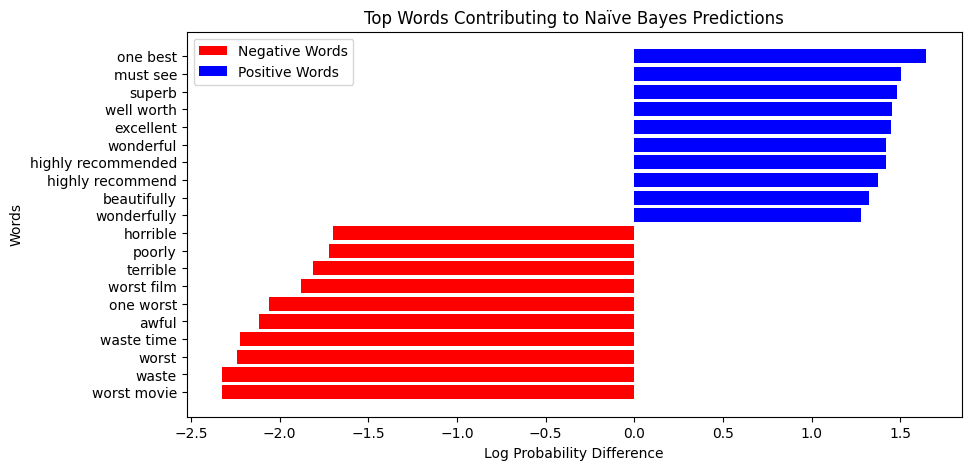

In [18]:
# Extract feature names and log probabilities
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
class_prob_diff = nb_best.feature_log_prob_[1] - nb_best.feature_log_prob_[0]

# Get top words contributing to positive and negative classifications
top_positive_words = feature_names[np.argsort(class_prob_diff)[-10:]]  # Most positive words
top_negative_words = feature_names[np.argsort(class_prob_diff)[:10]]   # Most negative words

# Create a bar chart
plt.figure(figsize=(10,5))
plt.barh(top_negative_words, np.sort(class_prob_diff)[:10], color='red', label="Negative Words")
plt.barh(top_positive_words, np.sort(class_prob_diff)[-10:], color='blue', label="Positive Words")
plt.xlabel("Log Probability Difference")
plt.ylabel("Words")
plt.title("Top Words Contributing to Naïve Bayes Predictions")
plt.legend()
plt.show()

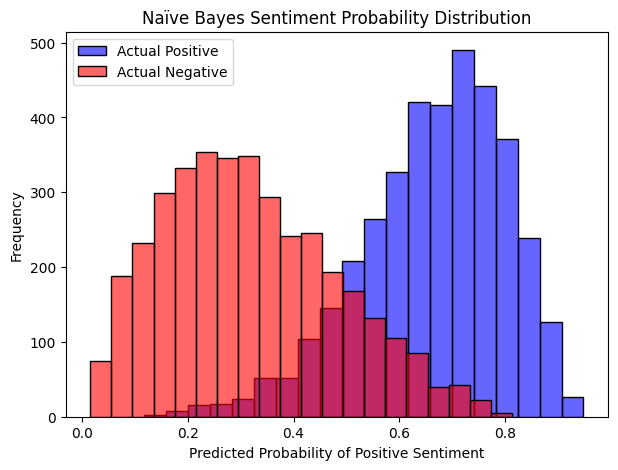

In [19]:
# Get predicted probabilities for the test set
y_probs_nb = nb_best.predict_proba(X_test_tfidf)[:, 1]  # Probability of positive class

# Plot distribution
plt.figure(figsize=(7,5))
sns.histplot(y_probs_nb[y_test == 1], bins=20, color="blue", label="Actual Positive", alpha=0.6)
sns.histplot(y_probs_nb[y_test == 0], bins=20, color="red", label="Actual Negative", alpha=0.6)
plt.xlabel("Predicted Probability of Positive Sentiment")
plt.ylabel("Frequency")
plt.title("Naïve Bayes Sentiment Probability Distribution")
plt.legend()
plt.show()

#### SVM

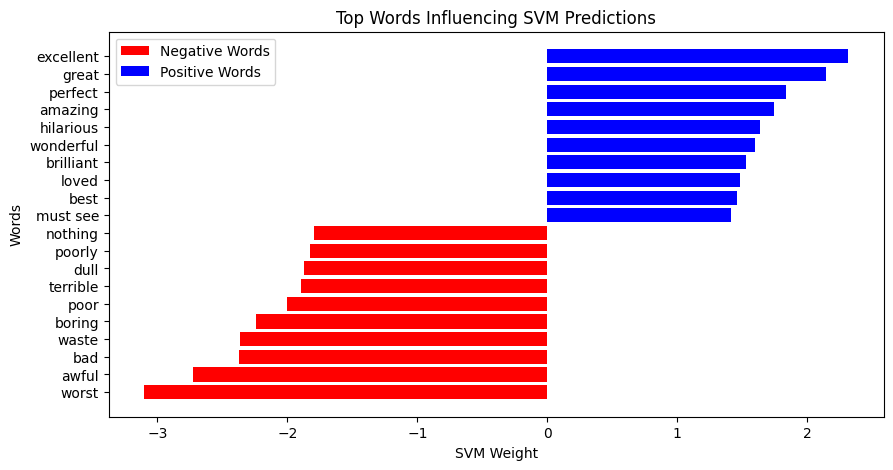

In [20]:
# Get feature names and coefficients from SVM
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
svm_weights = svm_best.coef_.flatten()

# Get top features for positive and negative sentiment
top_positive_words = feature_names[np.argsort(svm_weights)[-10:]]  # Most positive
top_negative_words = feature_names[np.argsort(svm_weights)[:10]]   # Most negative

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.barh(top_negative_words, np.sort(svm_weights)[:10], color='red', label="Negative Words")
plt.barh(top_positive_words, np.sort(svm_weights)[-10:], color='blue', label="Positive Words")
plt.xlabel("SVM Weight")
plt.ylabel("Words")
plt.title("Top Words Influencing SVM Predictions")
plt.legend()
plt.show()


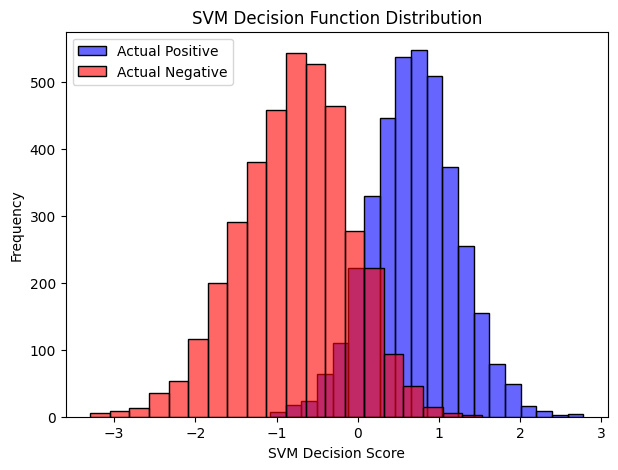

In [21]:
# Get decision scores (distance from hyperplane)
decision_scores = svm_best.decision_function(X_test_tfidf)

# Plot distribution of scores
plt.figure(figsize=(7,5))
sns.histplot(decision_scores[y_test == 1], bins=20, color="blue", label="Actual Positive", alpha=0.6)
sns.histplot(decision_scores[y_test == 0], bins=20, color="red", label="Actual Negative", alpha=0.6)
plt.xlabel("SVM Decision Score")
plt.ylabel("Frequency")
plt.title("SVM Decision Function Distribution")
plt.legend()
plt.show()

#### LSTM

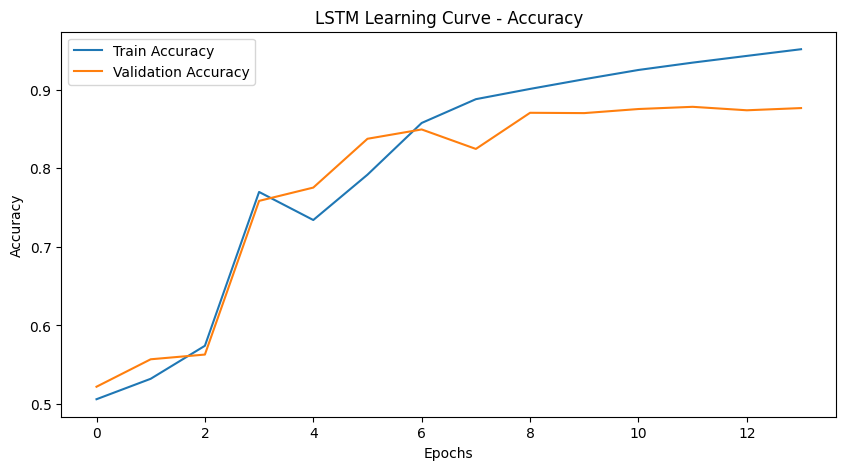

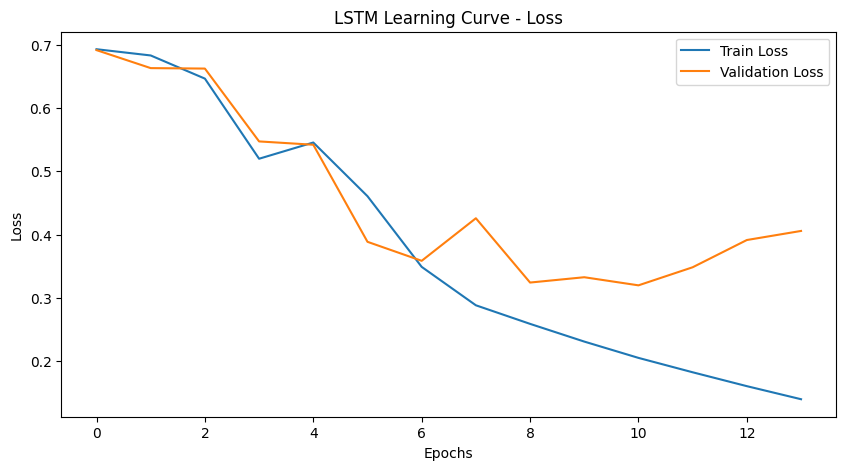

In [22]:
# Extract accuracy and loss from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("LSTM Learning Curve - Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Learning Curve - Loss")
plt.legend()
plt.show()

### Comparison

In [23]:
# Get performance reports
report_nb = classification_report(y_test, y_test_pred_nb, output_dict=True)
report_svm = classification_report(y_test, y_test_pred_svm, output_dict=True)
report_lstm = classification_report(y_test, y_test_pred_lstm, output_dict=True)

# Convert reports into DataFrames
df_results = pd.DataFrame({
    "Model": ["Naïve Bayes", "SVM", "LSTM"],
    "Accuracy": [report_nb["accuracy"], report_svm["accuracy"], report_lstm["accuracy"]],
    "Precision": [report_nb["weighted avg"]["precision"], report_svm["weighted avg"]["precision"], report_lstm["weighted avg"]["precision"]],
    "Recall": [report_nb["weighted avg"]["recall"], report_svm["weighted avg"]["recall"], report_lstm["weighted avg"]["recall"]],
    "F1-Score": [report_nb["weighted avg"]["f1-score"], report_svm["weighted avg"]["f1-score"], report_lstm["weighted avg"]["f1-score"]]
})

# Display results
display(df_results)

,Model,Accuracy,Precision,Recall,F1-Score
0,Naïve Bayes,0.863867,0.864271,0.863867,0.863829
1,SVM,0.891200,0.891562,0.891200,0.891175
2,LSTM,0.875467,0.875533,0.875467,0.875461


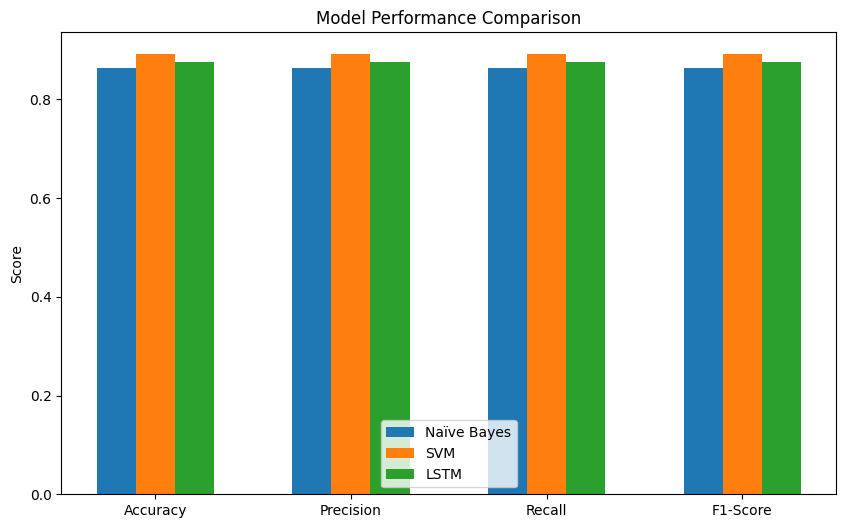

In [24]:
# Plot Performance Metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values_nb = [report_nb["accuracy"], report_nb["weighted avg"]["precision"], report_nb["weighted avg"]["recall"], report_nb["weighted avg"]["f1-score"]]
values_svm = [report_svm["accuracy"], report_svm["weighted avg"]["precision"], report_svm["weighted avg"]["recall"], report_svm["weighted avg"]["f1-score"]]
values_lstm = [report_lstm["accuracy"], report_lstm["weighted avg"]["precision"], report_lstm["weighted avg"]["recall"], report_lstm["weighted avg"]["f1-score"]]

x = np.arange(len(metrics))  # Label locations

plt.figure(figsize=(10,6))
plt.bar(x - 0.2, values_nb, 0.2, label="Naïve Bayes")
plt.bar(x, values_svm, 0.2, label="SVM")
plt.bar(x + 0.2, values_lstm, 0.2, label="LSTM")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step


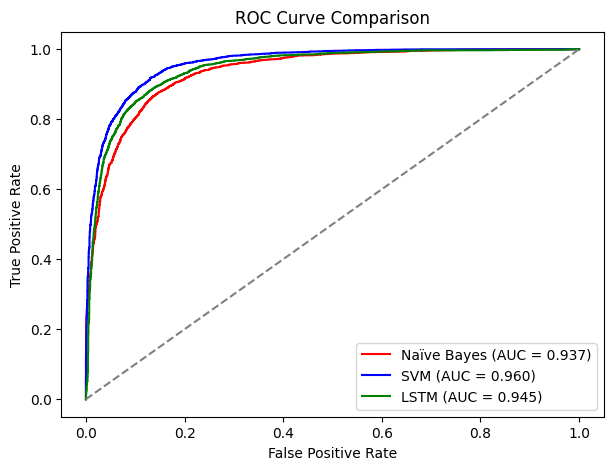

In [25]:
# Get predicted probabilities for Naïve Bayes and LSTM
y_probs_nb = nb_best.predict_proba(X_test_tfidf)[:, 1]  # Naïve Bayes gives probabilities directly
y_scores_svm = svm_best.decision_function(X_test_tfidf)  # SVM decision function scores
y_probs_lstm = lstm_model.predict(X_test_pad).flatten()  # LSTM sigmoid output

# Compute ROC curves
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_probs_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_scores_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_probs_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plot ROC curves
plt.figure(figsize=(7,5))
plt.plot(fpr_nb, tpr_nb, label=f"Naïve Bayes (AUC = {roc_auc_nb:.3f})", color='red')
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.3f})", color='blue')
plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM (AUC = {roc_auc_lstm:.3f})", color='green')

# Random classifier baseline
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

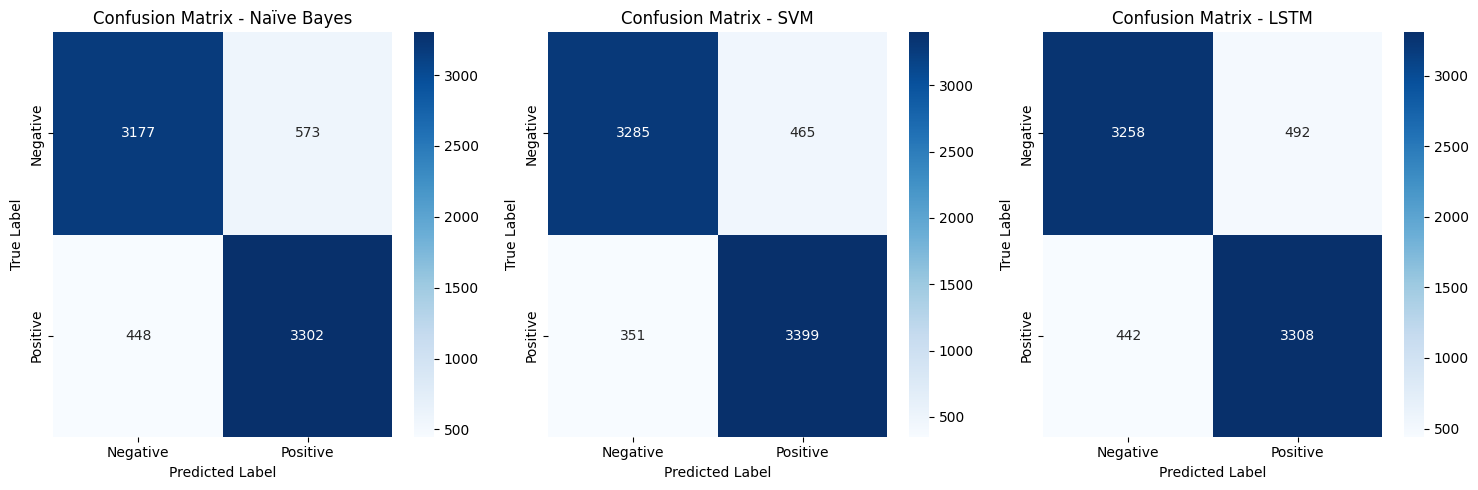

In [26]:
# Compute confusion matrices
cm_nb = confusion_matrix(y_test, y_test_pred_nb)
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
cm_lstm = confusion_matrix(y_test, y_test_pred_lstm)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
models = ["Naïve Bayes", "SVM", "LSTM"]
cms = [cm_nb, cm_svm, cm_lstm]

for ax, cm, model_name in zip(axes, cms, models):
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax)
  ax.set_xlabel("Predicted Label")
  ax.set_ylabel("True Label")
  ax.set_title(f"Confusion Matrix - {model_name}")

plt.tight_layout()
plt.show()